# Misidentifying People of the Same Race: Can my ML Perform Better?

### Objective
> During my tenure at Minerva, I've been assigned various names - these being the names of Black/African female-passing individuals in my class. Over time, I've managed to establish some individuality, and most people now remember my actual name. Nevertheless, it's disheartening to admit that a few classmates still misidentify me. 
>
> In our conversations, these fellow students share similar experiences of being misidentified. While I understand the existence of the cross-race effect and acknowledge instances where I've unintentionally misidentified others, it's crucial to highlight the problem when, after 3 years of interaction, a classmate continues to misidentify me.
>
> In my project, I aim to assess the effectiveness of my machine learning model in recognizing individuals from the same racial background—specifically. Can the model accurately differentiate between us and potentially surpass the performance of some of our classmates?

### Data Ethics and Collection
> The data utilized for this project was sourced primarily from my Google Photos, complemented by contributions from individuals who consented to participate. While I had amassed numerous photos myself, many were group shots where facial overshadowing occurred, or upon cropping, pixelation and compression occurred, posing challenges for accurate machine learning identification. To address this, I requested participants to share photos. This also ensured a more balanced distribution of classes.
> 
> The individuals whose data I gathered have granted permission exclusively for the purposes of this assignment. I've maintained transparency, informing them that only the write-up and code will be uploaded to my GitHub repository. They are comfortable with their names being shared in the write-up but have explicitly requested that only their faces be utilized.


### Data Cleaning, Conversion and Pre-processing
> Given that the raw data initially consisted of full-body photos, I attempted to extract only the faces using the Haar-Cascade classifier model in the hope of automating the process. Unfortunately, even after fine-tuning the model parameters such as ‘scaleFactor’ and ‘minNeighbors’ from the OpenCV library, its accuracy proved unsatisfactory.
>
> As a result, I opted for a manual approach, individually cropping out faces from the 530 images. Although this method was time-consuming, it yielded better results compared to the Haar Cascade classifier. Additionally, I needed to standardize the image formats to JPG or JPEG since the OpenCV library is most compatible with these formats. The majority of the images were in the HEIF format, making the conversion process time-consuming.
>
> To streamline the workflow and facilitate labeling, I further undertook the task of renaming the images using numerical identifiers. I assigned names ranging from 001 to 130 for the category `Edith`, 131 to 259 for `Noni`, 260 to 384 for `Aroma`, and 385 to 530 for `Macbeth`. This numbering system aimed to simplify the labeling process and maintain a cleaner, more organized dataset.
>
> The labels are converted to integers because the model and loss function in use, execute the classification only if the labels are converted to integers. In addition, the images are converted to numpy arrays which is the ideal data format for the libraries and model in use. These arrays’ entries are pixel values ranging from 0 to 255, and they are further normalized by dividing each array entry by 255. Normalizing is common practice in machine learning because it ensures that the networks perform better by ensuring that the variation in data ranges from 0 to 1. It also ensures faster convergence during backpropagation. Given that the weights are directly proportional to input values, smaller input values ensures the updates on the weights are performed within smaller scales as well.


In [2]:
import os
import pandas as pd
import numpy as np

def get_images(directory):
    """
    Returns a list of image paths in the given directory.

    Parameters:
    - directory: Directory to the images.
    
    Returns:
    - List of image paths.
    """
    image_paths = []
    
    # Iterate through each file in the directory
    for image_file in sorted(os.listdir(directory)):
        # Check if the file has a valid image extension
        if image_file.endswith(('.jpg', '.jpeg')):
            # Create the full path to the image
            image_path = os.path.join(directory, image_file)
            # Add the image path to the list
            image_paths.append(image_path)

    return image_paths


In [4]:
def get_labels(image_paths):
    """
    Returns a list of labels based on the given image paths.

    Parameters:
    - image_paths: List of image paths.
    
    Returns:
    - List of corresponding labels.
    """
    # Define ranges for each person's images
    label_ranges = {
        0: range(1, 131),  # Edith
        1: range(131, 260),  # Noni
        2: range(260, 385),  # Aroma
        3: range(385, 531)  # Macbeth
    }

    labels = []

    # Extract image numbers from image paths and determine labels
    for image_path in image_paths:
        # Extract the image number from the filename
        image_number = int(os.path.splitext(os.path.basename(image_path))[0])

        # Determine the label based on the image number
        person_label = None
        for person, number_range in label_ranges.items():
            if image_number in number_range:
                person_label = person
                break

        # If the image number doesn't fall into any range, skip it
        if person_label is not None:
            labels.append(person_label)

    return labels


In [5]:
def create_dataframe(directory):
    """
    Creates a dataframe of the image paths and their corresponding labels.

    Parameters:
    - directory: Directory to the images.
    
    Returns:
    - Dataframe of the images.
    """
    # Get image paths and labels using helper functions
    image_paths = get_images(directory)
    labels = get_labels(image_paths)

    # Create a dataframe
    dataframe = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    }, index=np.arange(1, len(image_paths) + 1))

    return dataframe


# Access the images
directory = "/Users/edithngundi/Downloads/Faces"

# Create the dataframe
df = create_dataframe(directory)

In [6]:
import cv2

def preprocess_images(directory, target_size):
    """
    Preprocess images from a list of file paths.

    Parameters:
    - directory: Directory to the images.
    - target_size: Tuple representing the desired size of the images (height, width).

    Returns:
    - List of preprocessed images.
    """

    # List to store preprocessed_images
    preprocessed_images = []
    
    # Get image paths
    image_paths = get_images(directory)

    # Iterate through image paths
    for image_path in image_paths:
        # Read the image
        image = cv2.imread(image_path)
        # Check if the image is readable
        if image is None:
            print(f"Error reading image: {image_path}")
            continue  # Skip to the next iteration
        # Check if there is an image
        if image.size == 0:
            print(f"Error: Empty image - {image_path}")
            continue  # Skip to the next iteration
        # Resize the image
        image = cv2.resize(image, target_size)
        # Add the resized images to the list
        preprocessed_images.append(image)
    return preprocessed_images

# input parameters
directory = "/Users/edithngundi/Downloads/Faces"
# ideal size for image classification models
target_size = (200, 200)


In [7]:
import numpy as np

# Function to normalize a list of images
def normalize_images(preprocessed_images):
    """
    Normalize a list of images by scaling pixel values to the range [0, 1].

    Parameters:
    - image_paths: List of image paths.

    Returns:
    - NumPy array of normalized images.
    """
    normalized_images = []
    for image in preprocessed_images:
        # Convert the image to a NumPy array and normalize pixel values
        normalized_image = image / 255.0
        normalized_images.append(normalized_image)

    return np.array(normalized_images)

preprocessed_images = preprocess_images(directory, target_size)
# input parameters
directory = "/Users/edithngundi/Downloads/Faces"
# ideal size for image classification models
target_size = (200, 200)

### Exploratory Data Analysis
> Given that this is a classification task, it’s important to check whether the classes in the dataset are balanced or if there is a significant imbalance. Class imbalance can lead to biased models, where the algorithm may become more inclined to predict the majority class, ignoring the minority class.The data for this problem is well-balanced amongst the 4 classes.
>
> In addition, displaying a few images is a great check for the quality and clarity of the images in the dataset. This is important because the quality of input data can significantly impact the performance of the machine learning model. It also verifies that the assigned labels match the content of the images. The images in this case are labelled correctly and are of good quality.


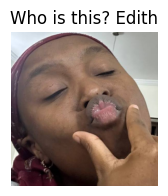

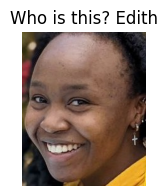

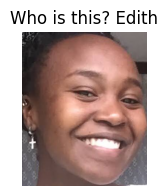

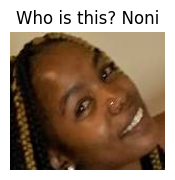

In [30]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Display a few random images with corresponding labels
def display_images(images, labels, number):
    """
    Display some random images along with their labels.

    Parameters:
    - images: List of image paths to be displayed.
    - labels: List of corresponding labels for the images.
    - number: Number of random images to display.
    """

    for _ in range(number):
        # Random selection of images
        index = random.randint(0, len(images) - 1)

        # Read the image using PIL
        image = Image.open(images[index])

        # Display the image
        plt.figure(figsize=(2, 2))
        plt.imshow(image)

        # Map label to a corresponding name
        name = ''
        if labels[index] == 0:
            name = 'Edith'
        elif labels[index] == 1:
            name = 'Noni'
        elif labels[index] == 2:
            name = 'Aroma'
        elif labels[index] == 3:
            name = 'Macbeth'

        # Display images
        plt.title(f'Who is this? {name}')
        plt.axis('off')
        plt.show()

# Set the number of images to be displayed
number = 4

# Directory
directory = "/Users/edithngundi/Downloads/Faces"

# Dataframe
df = create_dataframe(directory)

# Extract the 'image_path' column
images = df['image_path'].values

# Extract the 'label' column
labels = df['label'].values

# Display images
display_images(images, labels, number)

/Users/edithngundi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edithngundi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edithngundi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


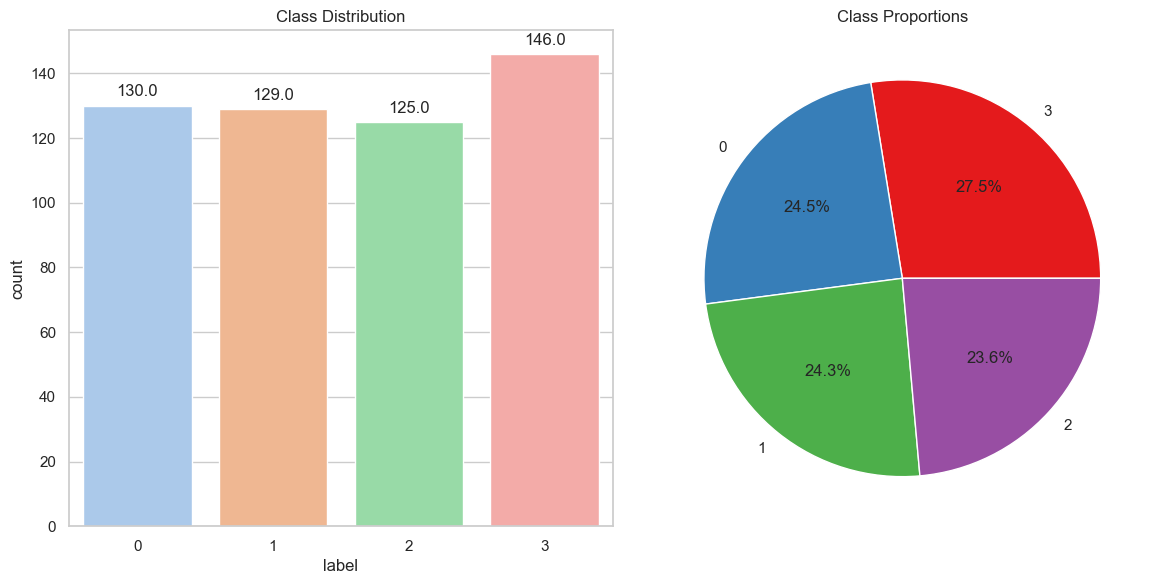

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose display style
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Bar graph for class distribution
x = sns.countplot(x='label', data=df, palette='pastel')
for person in x.patches:
    x.annotate(f'{person.get_height()}', (person.get_x() + person.get_width() / 2., person.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Class Distribution')

# Pie chart for class distribution
plt.subplot(1, 2, 2)
counts = df['label'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set1'))
plt.title('Class Proportions')

# Display plot
plt.tight_layout()
plt.show()


### Data Classification
> The image classification task will be performed using a `Convolutional Neural Network (CNN)` that implements a simple architecture. CNNs are well-suited for image classification tasks as they can automatically learn hierarchical representations of features from the input images. 
>
> The dataset has been divided into `training` and `testing` sets using the `80-20` split. The training set (80%) is used to train the model, and the testing set (20%) is reserved for evaluating the model's performance on unseen data. This helps ensure that the model generalizes well to new, unseen examples.
>
> Within the `training` set, an additional `80-20` split has been performed to create a `validation` set. This is a strategy to monitor the model's performance during training and prevent overfitting. The validation set is not used for training but is crucial for tuning hyperparameters and assessing the model's performance on data it has not seen during training.
>
> In this image classification tasks, the model will be evaluated on `accuracy`. This metric provide insights into how well the model is performing in terms of correctly classifying instances and avoiding misclassifications. Choices on specific tuning parameters will be made based on an ideal trade-offs.

In [32]:
from sklearn.model_selection import train_test_split
# Normalized images
image_data = normalize_images(preprocessed_images)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

### Model Selection
> Convolutional Neural Network (CNN) consists of multiple layers, each serving a specific purpose in classification. There are two underlying hypotheses that we must assume when building any neural network: 
> - `Linear independence of the input features`
> - `Low dimensionality of the input space`. 
>
> The data typically processed with CNNs doesn’t usually satisfy either of these hypotheses. With the architecture of CNN, neurons of the hidden layers learn possible abstract representations over their input, which typically decrease its dimensionality (Baeldung, 2023). The network then assumes that these abstract representations, and not the underlying input features, are independent of one another. These abstract representations are normally contained in the hidden layer of a CNN and tend to possess a lower dimensionality than that of the input. A CNN thus helps solve the so-called `Curse of Dimensionality` problem, which refers to the exponential increase in the amount of computation required to perform a machine-learning task in relation to the unitary increase in the dimensionality of the input (Baeldung, 2023).
>
> #### 1. Convolutional layers
> To understand the underpinnings of this layer, it's important to look into the `filter` and two critical hyperparameters, `stride` and `padding`.
> 
> The `filter` also known as `kernel` is a small matrix used for the convolution operation. The `convolution operation` involves sliding the filter over the input data, performing element-wise multiplication at each step, and summing the results to produce a single value in the output feature map.
>
> The dimensions of the filter depend on the channels of the image data points. If they are in `RGB`, then the channels are `3`. Therefore, the filter is a `3x3` matrix.
>
> A convolutional layer typically uses multiple filters simultaneously. Each filter is responsible for capturing a different feature or pattern in the input data. 
>
> During convolution, the filter slides from left to right and from top to bottom until it passes through the entire input image. The `stride` is the step the filter takes. Performing matrix multiplication with images represented as high-dimension matrices is computationally expensive (Antoniadis, 2023).
>
> To reduce the load, `downsampling`, which is essentially reduces the spatial dimensions of the image, is often used. This operation is done by setting `stride > 0`. If this is set to `1` for instance, then the filter matrix will skip `1` row and `1` column as it slides over to perform the matrix multiplication. Given that the dataset in this project is comparatively small, downsampling was not performed.
>
> In the convolutional layer, the pixels located on the corners and the edges are used much less than those in the middle. For instance, if the input image is a `5x5` matrix and the filter is a `3x3` matrix, as the filter slides on the image matrix, the input's central pixel at position `(3,3)` is used `9 times` while the corner pixels `(0,0)`, `(0,5)`, `(5,0)` and `(5,5)` are used `1 time` (Antoniadis, 2023).
>
> Therefore, the information on the borders of images is not preserved as well as the information in the middle. A simple and powerful solution to this problem is `padding`, which adds rows and columns of zeros to the input image. 
>
> If we apply padding $P$ in an input image of size $W{\times}H$, the output image has dimensions $(W+2P){\times}(H+2P)$. This is because the padding is added to the left, right, top and bottom of the input image matrix. In the example with a `5x5` matrix, if padding is set to $P=2$, then the resulting input image matrix is of dimensions `9x9`(Antoniadis, 2023). This is a complex step that I felt inexperienced to look into, so for this model the padding is set to `same` which ensures the output is the same dimension as the input.
>
> The output of the convolutional layer is an output activation map which is computed using the following inputs (Antoniadis, 2023):
> - An input image of dimensions $W_{in} \times H_{in}$
> - A filter of dimensions $k \times k$
> - Stride $s$
> - Padding $p$
>
> The resulting dimensions of the output activation map are:
> 
> $$ W_{out} = \frac{W_{in} - k + 2p + s} {s} $$
> $$ H_{out} = \frac{H_{in} - k + 2p + s} {s} $$
>
> This task implements 'same' padding, where the size of the input is kept unchanged after the convolutional layer. So for this case:
> $$ W_{out} = W_{in} $$
> $$ H_{out} = H_{in} $$
>
> #### 2. Pooling layers
>
> The dimensions of the input data and the parameters of the neural network play a crucial role. So this number can be controlled by the stacking of one or more pooling layers. Depending on the type of the pooling layer, an operation is performed on each channel of the input data independently to summarize its values into a single one and thus keep the most important features (Nanos, 2023).
>
> The choice to use the max pooling technique was completely arbitrary. This technique first breaks down an input image matrix into submatrices of a specific dimension. For instance, if the input matrix is `4x4`, a suitable breakdown is having `4` submatrices that are of dimension `2x2`. These dimensions `2x2` are know as the `pool size`. I set a similar pool size for my model's max pooling layer.
>
> Next, the technique chooses the maximum value from each of the 4 submatrices and constructs a `2x2` matrix with these values - hence why it's called max pooling.
>
> This method maintains the most significant features of the input by reducing its dimensions. The mathematical formula of max pooling is (Nanos, 2023):
>
> $$ MaxPooling(X)_{i,j,k} = \underset{\text{m,n}}{\text{max}} \; X_{i \cdot s_x + m,j \cdot s_y + n,k}$$
>
> where $X$ is the input image, $(i,j)$ are the indices of the output, $k$ is the image channel index, $s_x$ and $s_y$ are the stride values in the horizontal and vertical directions, and the and the pooling window is defined by the filter size $f_x$ and $f_y$ centered at the output index $(i,j)$ (Nanos, 2023).
>
> #### 3. Dropout layer
>
> The `Dropout layer` is a hidden layer that randomly "drops out" (sets to zero) a certain fraction of the neurons during training at each update, effectively making them inactive for that particular iteration. 
>
> A Dropout layer can be applied to the input vector, in which case it nullifies some of its features; but we can also apply it to a hidden layer, in which case it nullifies some hidden neurons (Baeldung, 2023). I implemented the latter for my model.
> 
> Dropout layers are important in training CNNs because they prevent overfitting on the training data. If absent, the first batch of training samples influences the learning in a disproportionately high manner (Baeldung, 2023).
>
> The choice to have a dropout rate of `0.5` in my model was arbitrary. This means the Dropout hidden layer would randomly drop out 50% of the neurons during training.
>
> #### 4. Fully connected layers
> 
> They are of different types, however most of them are where the weights are applied and learned during the training process.
>
> The `Flatten layer` takes the output of previous layers (convolutional and max-pooling layers) and flattens them into single vectors that will be passed forward as inputs. No weights are assigned here, it is purely used for reshaping the data.
>
> The `First Fully Connected layer` takes single vector inputs and applies weights to predict the appropriate labels for the images. My model has `128` neurons and uses the `ReLU activation function`. Weights are applied to the flattened input data for each neuron, and the ReLU activation function introduces non-linearity by squishing the linear transformation of each input.
>
> The computation is as follows:
>
> $$ Z = X \cdot W + b $$ 
> $$ A = ReLU(Z) = max(0,Z) $$
>
> where $X$ is the input vector, $W$ is the weight vector, $b$ is the bias term, and $Z$ is the linear transformation of the input. The ReLU function replaces any negative values with zero and leaves positive values unchanged - this introduces non-linearity. The linear transformations and activations occur in parallel for each neuron.
>
> The `Fully Connected Output layer` also known as `Soft-max Activation Layer` gives the final probabilities for each label (Kalita, 2022). In my model, the output is mapped to a probability distribution using the softmax function. The number of neurons here depends on the number of labels in the input data, in this case `4` units. 
>
> Using an arbitrary example, suppose the activation values $(A)$ for the four classes in my model were  $A_0$=1.5, $A_1$=1.3, $A_2$=1.1, $A_3$=1.7, then the softmax activation function will calculate probabilities for each class as follows:
>
> $$ softmax(A_0) = \frac {exp(1.5)} {exp(1.5) + exp(1.3) + exp(1.1) + exp(1.7)}$$
> $$ softmax(A_1) = \frac {exp(1.3)} {exp(1.5) + exp(1.3) + exp(1.1) + exp(1.7)}$$
> $$ softmax(A_2) = \frac {exp(1.1)} {exp(1.5) + exp(1.3) + exp(1.1) + exp(1.7)}$$
> $$ softmax(A_3) = \frac {exp(1.7)} {exp(1.5) + exp(1.3) + exp(1.1) + exp(1.7)}$$


In [9]:
# Code adapted from Analytics Vidhya by Devansh Sharma — Updated On June 14th, 2023
# Step 8: Define, Compile and Train the CNN Model
# Code adapted from Analytics Vidhya by Mohdsanadzakirizvi@gmail.com Sanad — Updated On July 11th, 2023

import tensorflow as tf

# Training data batch size
batch_size = 15
# Number of classes
classes = 4
# Number of epochs
epochs = 10
# Image channel 
rgb = 3
# Number of output filters in the convolution
filters = 32
# Window size over which the maximum is taken
pool_size = (2, 2)
# Specifies the height and width of the 2D convolution window
kernel_size = (3, 3)
# Pads with zeros evenly to the left/right or up/down of the input
padding = 'same'
# Fraction of the input units to drop
rate = 0.5

# CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding=padding, activation='relu', input_shape=(target_size[0], target_size[1], rgb)), #convolutional layer
    tf.keras.layers.MaxPooling2D(pool_size), # down-samples the spatial dimensions of the input data
    tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding=padding, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size), 
    tf.keras.layers.Dropout(rate), # drop input units
    tf.keras.layers.Flatten(), #flatten the output of the previous layers
    tf.keras.layers.Dense(units=128, activation='relu'), #hidden layer fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(units=classes, activation='softmax') #output layer
])


/Users/edithngundi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Model Training
> Training the neural network involves iteratively updating the weights to minimize the loss function using an optimization method and backpropagation. For classification tasks, the common choice for a loss function is the cross-entropy function. The loss/cost function measures the error in the model's performance. This error is the difference between the predicted values and the actual values. 
>
> The `sparse_categorical_crossentropy` function is often used in scenarios where classes are mutually exclusive, such as this task. It calculates the cross-entropy loss between the predicted probabilities and the true class labels which means it measures the dissimilarity between the predicted distribution and the true distribution of class labels.
>
> The `optimizer` is a method set within the model's `compile` method that performs the backpropagation operation. It adjusts the weights of the neural network in order to minimize the loss function and is responsible for updating the model's parameters during training. The choice of the `adam` optimizer was completely arbitrary. The Adam optimizer is popular and effective, and it combines the ideas of the `momentum` and `RMSprop (Root Mean Square Propagation)` to gradually adjust learning rates for each parameter.
>
> The total number of image datapoints was `530`. The first 80-20 split sets the `training` datapoints to be `424` and the `test` datapoints to be `106`. A second 80-20 split is performed on the training datapoints making the `effective training set` to be `339` and the `validation set` to be `85`. Given that the `batch size` is `15`, the number of batches needed to process the entire effective training set would be:
>
> $$ batches = \frac {339} {15} = 22.6 $$
>
> However, when determining the number of batches, the value is rounded up to the nearest integer because in practice, a batch cannot be a fraction. So, the correct number of batches is `23`.
>
> An `epoch` is one complete iteration the entire training dataset during the training of a neural network. Each of the 23 batches is iterated over in each epoch. During an epoch, the model's parameters (weights and biases) are updated based on the gradients of the loss function with respect to these parameters.
>
> Training for too many epochs may lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new, unseen data. On the other hand, too few epochs might result in underfitting, where the model has not learned the underlying patterns well enough. To monitor the model's performance during training, a validation set is often used. After each epoch, the model's performance is evaluated on the validation set. Finding an ideal number of epochs depends on the context of the task and nature of data.

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
training_history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
23/23 [==============================] - 8s 306ms/step - loss: 2.0178 - accuracy: 0.2979 - val_loss: 1.3736 - val_accuracy: 0.2471
Epoch 2/10
23/23 [==============================] - 8s 367ms/step - loss: 1.3271 - accuracy: 0.3599 - val_loss: 1.2193 - val_accuracy: 0.5059
Epoch 3/10
23/23 [==============================] - 8s 351ms/step - loss: 0.9893 - accuracy: 0.6018 - val_loss: 1.0985 - val_accuracy: 0.5059
Epoch 4/10
23/23 [==============================] - 9s 377ms/step - loss: 0.6167 - accuracy: 0.7463 - val_loss: 1.0004 - val_accuracy: 0.5412
Epoch 5/10
23/23 [==============================] - 6s 275ms/step - loss: 0.3189 - accuracy: 0.9204 - val_loss: 0.9972 - val_accuracy: 0.6118
Epoch 6/10
23/23 [==============================] - 6s 250ms/step - loss: 0.1994 - accuracy: 0.9440 - val_loss: 0.9646 - val_accuracy: 0.5765
Epoch 7/10
23/23 [==============================] - 6s 256ms/step - loss: 0.0782 - accuracy: 0.9882 - val_loss: 1.0839 - val_accuracy: 0.6118
Epoch 

In [11]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 flatten (Flatten)           (None, 80000)             0

### Predictions 
> These are the predictions the model generated based on the hyperparameters I have discussed earlier. The model's acuracy is not ideal and this could be attributed to the fact that most of the hyperparameters were chosen arbitrarily.

4/4 [==============================] - 1s 164ms/step


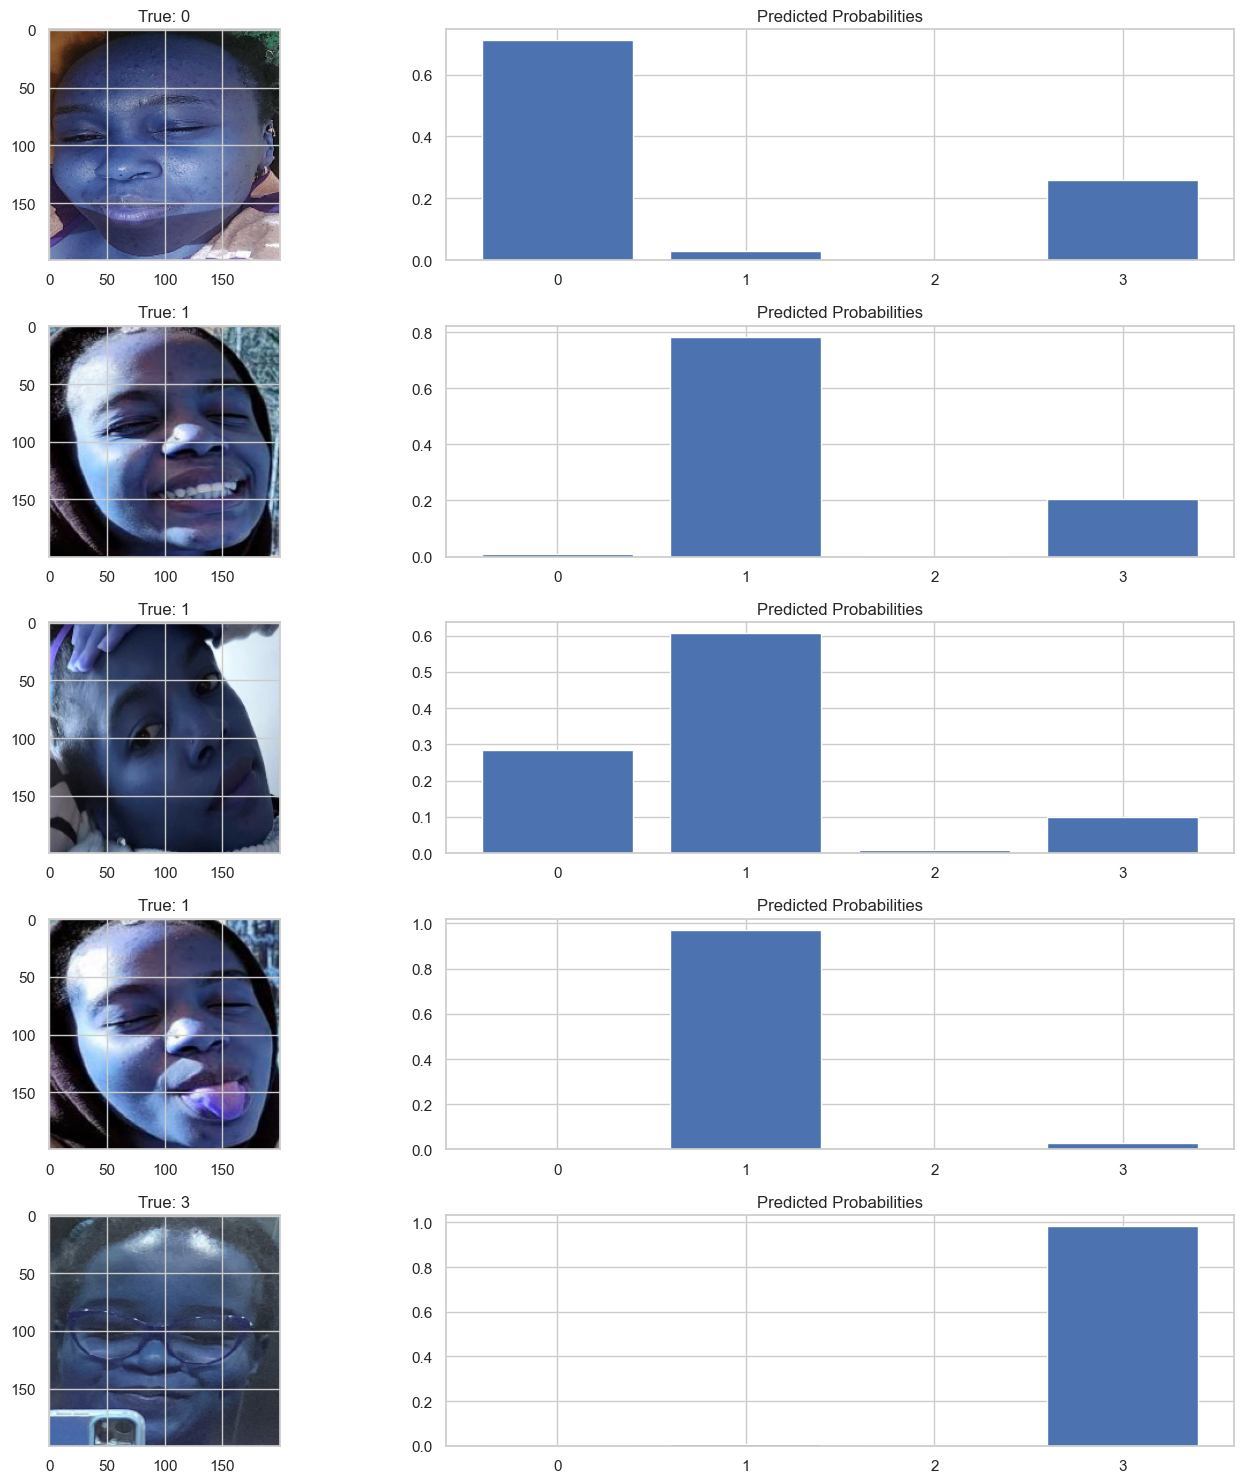

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, X_test, y_test, num_samples=5):
    # Generate predictions
    y_pred = model.predict(X_test)

    # Randomly select num_samples samples
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(15, 3 * num_samples))

    for i, sample_index in enumerate(sample_indices, 1):
        plt.subplot(num_samples, 2, 2 * i - 1)
        plt.imshow(X_test[sample_index])
        plt.title(f"True: {y_test[sample_index]}")

        plt.subplot(num_samples, 2, 2 * i)
        plt.bar(range(classes), y_pred[sample_index], tick_label=range(classes))
        plt.title("Predicted Probabilities")

    plt.tight_layout()
    plt.show()

# y_test is a pandas DataFrame
y_test_array = y_test.values 

# Now y_test_array is a NumPy array or list
visualize_predictions(model, X_test, y_test_array)

# Visualizations and Performance Metrics
> The following hyperparameters can be tuned to ensure that the model performs optimally: `batch size`, `number of epochs`, `filters`, `pool size`, `kernel size`, `padding` and ` drop out rate`.
>
> I attempted to use the `KerasClassifier` wrapper to my model and used `GridSearchCV` to perform hyperparameter tuning but that proved ineffective on several attempts. I resorted to manually trying different hyperparameter values and found that though the current values are not optimal, the `accuracy` of the model is not too inefficient.
>
> Below are plots showing the relationship between `loss` and `accuracy` of the training and validation sets and the number of epochs.
>
> In the code, `val_loss` looks at the error on the validation data and `loss` looks at the error on the training data. From the Model Loss visualization, the training error reduces significantly as the number of epochs increases, a huge discrepancy from the validation error graph. 
>
> Similarly, `val_accuracy` looks at the accuracy on the validation data and `accuracy` looks at the accuracy on the training data. The training accuracy increases as number of epochs increases, while the accuracy of the validation set sort of plateaus between 0.5 and 0.6. 
>
> These discrepancies indicate overfitting. Overfitting occurs when a model performs well on the training data but fails to generalize to new, unseen data, as indicated by a poor performance on the validation set. 
>
> Given that the image datapoints of this model are just 530, it is difficult to come up with a high performing model. Therefore, to prevent underfitting and overfitting, I chose to use 10 epochs

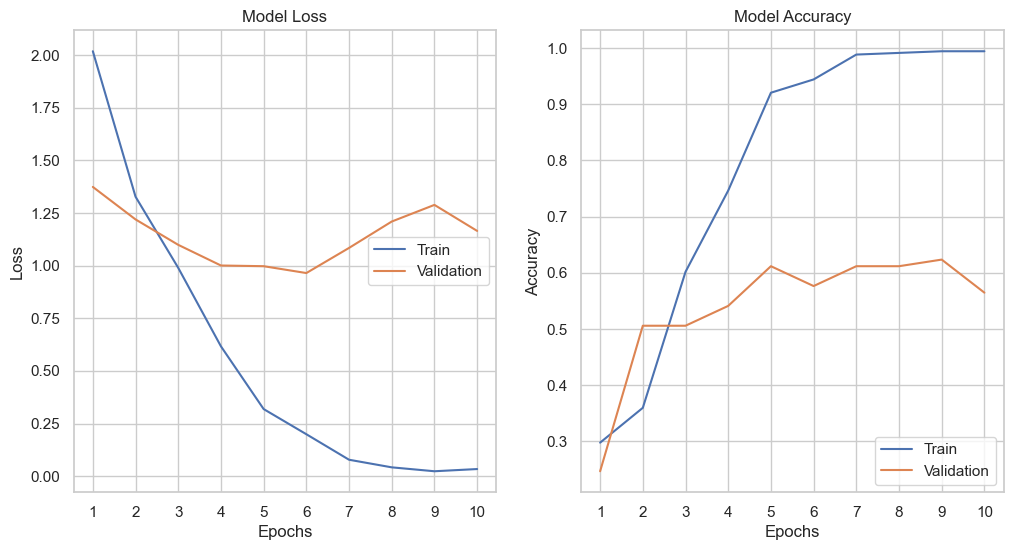

In [13]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot training and validation loss values
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='center right')

# Set x-axis ticks to be integers (epochs)
plt.xticks(range(0, len(training_history.history['loss'])), range(1, len(training_history.history['loss']) + 1))

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')

# Set x-axis ticks to be integers (epochs)
plt.xticks(range(0, len(training_history.history['accuracy'])), range(1, len(training_history.history['accuracy']) + 1))

plt.show()

Epoch 1/20
23/23 [==============================] - 12s 500ms/step - loss: 0.0086 - accuracy: 0.9941 - val_loss: 3.7878 - val_accuracy: 0.5882
Epoch 2/20
23/23 [==============================] - 11s 491ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.5695 - val_accuracy: 0.5529
Epoch 3/20
23/23 [==============================] - 11s 485ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.2511 - val_accuracy: 0.5176
Epoch 4/20
23/23 [==============================] - 11s 469ms/step - loss: 6.0211e-04 - accuracy: 1.0000 - val_loss: 2.9655 - val_accuracy: 0.6000
Epoch 5/20
23/23 [==============================] - 10s 455ms/step - loss: 1.5422e-04 - accuracy: 1.0000 - val_loss: 3.0348 - val_accuracy: 0.5765
Epoch 6/20
23/23 [==============================] - 10s 452ms/step - loss: 7.3840e-05 - accuracy: 1.0000 - val_loss: 2.9675 - val_accuracy: 0.5882
Epoch 7/20
23/23 [==============================] - 10s 453ms/step - loss: 3.3931e-05 - accuracy: 1.0000 - val_loss: 2.7539 - val_

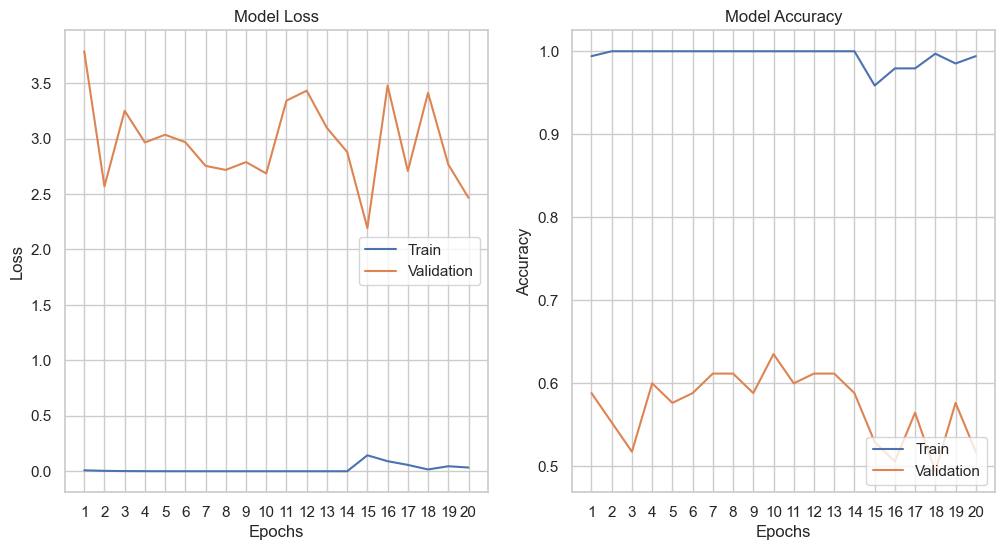

In [16]:
import matplotlib.pyplot as plt
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
# Set the number of epochs to 20 to see a lengthier trend
training_history1 = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(training_history1.history['loss'])
plt.plot(training_history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='center right')

# Set x-axis ticks to be integers (epochs)
plt.xticks(range(0, len(training_history1.history['loss'])), range(1, len(training_history1.history['loss']) + 1))

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_history1.history['accuracy'])
plt.plot(training_history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')

# Set x-axis ticks to be integers (epochs)
plt.xticks(range(0, len(training_history1.history['accuracy'])), range(1, len(training_history1.history['accuracy']) + 1))

plt.show()

In [17]:
score = model.evaluate(X_test, y_test, verbose = 0 )
test_loss = score[0]
test_accuracy = score[1]
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  2.8296759128570557
Test accuracy:  0.49056604504585266


### Executive Summary
> #### Objective:
> This project aims to address the persistent issue of misidentification in a diverse academic setting by leveraging machine learning. The focus is on assessing the effectiveness of a Convolutional Neural Network (CNN) in recognizing individuals from the same racial background, specifically exploring the names Aroma, Macbeth, Noni, and Edith (the author). The overarching goal is to develop a model capable of surpassing the performance of classmates in distinguishing between these individuals.
>
> #### Data Ethics and Collection:
> The project utilizes data primarily sourced from Google Photos and supplemented by contributions from consenting individuals. Challenges in accurate machine learning identification, such as facial overshadowing and image format issues, prompted a transparent approach in requesting participants to share photos. Participants have granted permission exclusively for this assignment, with a commitment to maintaining privacy by sharing only faces and not full names.
>
> #### Data Cleaning, Conversion, and Pre-processing:
> To enhance model accuracy, a manual approach was employed to extract faces from images, overcoming limitations of automated methods. Standardizing image formats, renaming files, and converting labels to integers were essential steps. Normalization of pixel values and careful consideration of data dimensions were undertaken to optimize the dataset for machine learning.
>
> #### Exploratory Data Analysis:
> Ensuring a balanced dataset among the four classes was crucial for model performance. Quality checks on image clarity and correct labeling were conducted to guarantee reliable input data for the machine learning model.
>
> #### Data Classification:
> A Convolutional Neural Network (CNN) was chosen for image classification, with a focus on evaluating accuracy. The dataset was split into training and testing sets, with further validation set creation to monitor model performance during training and prevent overfitting.
>
> #### Model Selection:
> The CNN architecture incorporates convolutional layers, pooling layers, dropout layers, and fully connected layers. Detailed explanations were provided for each layer type, highlighting their role in image classification. The rationale behind choices of hyperparameters were explained.
>
> #### Model Training:
> Training involved the use of the sparse categorical cross-entropy loss function and the Adam optimizer. Hyperparameter tuning was explored manually, and the challenges of finding an optimal balance between underfitting and overfitting were discussed. Visualizations were provided to illustrate the model's performance over epochs.
>
> #### Predictions:
> Model predictions were presented, acknowledging that hyperparameters may not be optimal. The need for further tuning to improve accuracy was emphasized. The model can be optimized by using more data and more robust methods of hyperparameter tuning. The latter was not explored because of limited knowledge.
>
> #### Visualizations and Performance Metrics:
> Visualizations of training and validation loss, accuracy, and the number of epochs were included. Discrepancies between training and validation metrics indicated potential overfitting, prompting a cautious approach to model complexity.
>
> In conclusion, while the current model shows promise, ongoing refinement of hyperparameters and model architecture is recommended to achieve optimal performance in recognizing individuals from the same racial background.


### References
> Antoniadis, W. by: P. (2023, April 14). Calculate the output size of a convolutional layer. Baeldung on Computer Science. https://www.baeldung.com/cs/convolutional-layer-size 
>
> Cross entropy loss: Intro, applications, code. V7. (n.d.). https://www.v7labs.com/blog/cross-entropy-loss-guide#:~:text=Cross%2Dentropy%20loss%20measures%20the,is%20the%20cross%2Dentropy%20function 
>
> Fully connected layers in convolutional neural networks. IndianTechWarrior. (2023, August 22). https://indiantechwarrior.com/fully-connected-layers-in-convolutional-neural-networks/ 
>
> Kalita, D. (2022, March 22). Basics of CNN in Deep Learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2022/03/basics-of-cnn-in-deep-learning/ 
>
> Koech, K. E. (2021, November 18). Softmax activation function - how it actually works. Medium. https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78 
>
> Kumar, A. (2020, October 28). Keras - categorical cross entropy loss function. Analytics Yogi. https://vitalflux.com/keras-categorical-cross-entropy-loss-function/#:~:text=sparse_categorical_crossentropy%3A%20Used%20as%20a%20loss,just%20has%20a%20different%20interface. 
>
> Mittal, A. (2021, June 26). Haar Cascades, explained. Medium. https://medium.com/analytics-vidhya/haar-cascades-explained-38210e57970d 
>
> Team, K. (n.d.). Keras documentation: Probabilistic losses. https://keras.io/api/losses/probabilistic_losses/#sparse_categorical_crossentropy-function 
>
> Tf.keras.model&nbsp; :&nbsp;  tensorflow V2.14.0. TensorFlow. (n.d.-a). https://www.tensorflow.org/api_docs/python/tf/keras/Model 
>
> Training &amp; Evaluation with the built-in methods&nbsp; :&nbsp;  Tensorflow Core. TensorFlow. (n.d.-b). https://www.tensorflow.org/guide/keras/training_with_built_in_methods 
>
> Wong, H. K., Stephen, I. D., &amp; Keeble, D. R. T. (2020, January 29). The own-race bias for face recognition in a multiracial society. Frontiers. https://www.frontiersin.org/articles/10.3389/fpsyg.2020.00208/full 